In [15]:
IMAGE_SIZE = [224, 224]
TRAINING_PATH = '/home/dilara/UGI-endoscopy/training-data'
TESTING_PATH = '/home/dilara/UGI-endoscopy/testing-data'
CLASSES = ['other2', 'pylorus', 'z-line', 'retroflex-stomach']

import keras
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Dropout 
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import skimage
from skimage import io
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sbs
from PIL import Image

def get_paths(path):
## setting the paths
    all_paths = []
    for landmark in CLASSES:
        other_path = os.path.join(path, landmark, '*')
        all_paths.append(sorted(glob.glob(other_path)))
    return all_paths
# all_paths = list(np.concatenate(all_paths).flat)

def get_class_num(path):
## finding the number of image per class
    len_lis = []
    for lis in path:
        x = 0
        for item in lis:
            x+=1
        len_lis.append(x)
    print(len_lis)
    return len_lis

def create_labels(len_lis):
    labels_lis = []
    for i in range(len(CLASSES)):
        labels_lis.append([i] * len_lis[i])
        all_labels = list(np.concatenate(labels_lis).flat)
        all_labels = np.array(all_labels)
    return all_labels

all_paths_train = get_paths(TRAINING_PATH)
all_paths_test = get_paths(TESTING_PATH)
len_lis_train = get_class_num(all_paths_train)
len_lis_test = get_class_num(all_paths_test)

all_paths_train = list(np.concatenate(all_paths_train).flat)
all_paths_test = list(np.concatenate(all_paths_test).flat)

all_labels_train = create_labels(len_lis_train)
all_labels_test = create_labels(len_lis_test)
print(len(all_labels_train))

[6321, 6993, 6524, 5348]
[3260, 586, 147, 230]
25186


In [16]:
## Augmenting the Dataset
# for path in all_paths:
# 	file_name = path[:len(path)-4]
# 	image = cv2.imread(path)
# 	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# 	rows, cols, dim = image.shape

# 	# flipping images upside down and leftright
# 	image_fliplr = np.fliplr(image)
# 	image_flipud = np.flipud(image)
# 	plt.imsave(f'{file_name}_image_flipud.jpg', image_flipud)
# 	plt.imsave(f'{file_name}_image_fliplr.jpg', image_fliplr)

# 	# rotating image
# 	rotated_img = skimage.transform.rotate(image, 90)
# 	plt.imsave(f'{file_name}_rotated_img.jpg', rotated_img)

# 	# shear transform on x-axis
# 	M = np.float32([[1, 0.7, 0],
# 					[0, 1  , 0],
# 					[0, 0  , 1]])             
# 	sheared_img = cv2.warpPerspective(image,M,(int(cols*1.5),int(rows*1.5)))
# 	plt.imsave(f'{file_name}_sheared_img.jpg', sheared_img)

# 	## zoom out
# 	M = np.float32([[1.5, 0  , 0],
# 					[0,   1.5, 0],
# 					[0,   0,   1]])
# 	scaledin_img = cv2.warpPerspective(image,M,(cols,rows))
# 	plt.imsave(f'{file_name}_scaledin_img.jpg', scaledin_img)

# 	M = np.float32([[0.8, 0  , 0],
# 					[0,   0.8, 0],
# 					[0,   0,   1]])
# 	scaledout_img = cv2.warpPerspective(image,M,(cols,rows))
# 	plt.imsave(f'{file_name}_scaledout_img.jpg', scaledout_img)

In [38]:
# # Renaming the images
# all_paths_test = []

# for landmark in CLASSES:
#     other_path = os.path.join(TESTING_PATH, landmark, '*')
#     all_paths_test.append(sorted(glob.glob(other_path)))

# all_paths_test = list(np.concatenate(all_paths_test).flat)

# for path in all_paths_test:
#     old = path
#     new = f'{path[:len(path)-4]}_video5.jpg'
#     os.rename(old, new)

In [ ]:
# ## Crop testing images
# from PIL import Image
 
# # Opens a image in RGB mode
# for path in all_paths_test:
#     im = Image.open(path)
#     width, height = im.size
#     left = (width/3) + 25
#     top = 0
#     right = 1920
#     bottom = height

#     im1 = im.crop((left, top, right, bottom))
#     im1 = im1.save(path)

In [16]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

def get_pix(path_lis):
    pix = []
    for path in path_lis:
        image = load_img(path, color_mode='rgb', target_size=IMAGE_SIZE)
        image = img_to_array(image)
        image = preprocess_input(image)
        pix.append(image)
    return pix

pix_train = get_pix(all_paths_train)
pix_test = get_pix(all_paths_test)
print(len(pix_train))

pix_train = np.array(pix_train)
pix_test = np.array(pix_test)

pix_train, pix_val, label_train, label_val = train_test_split(pix_train, all_labels_train, train_size=0.75, random_state = 42)

label_train = keras.utils.np_utils.to_categorical(label_train, num_classes=len(CLASSES))
label_val = keras.utils.np_utils.to_categorical(label_val, num_classes=len(CLASSES))
label_test = keras.utils.np_utils.to_categorical(all_labels_test, num_classes=len(CLASSES))



25186


In [17]:
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg.layers[:15]:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) 
x = Dense(256, activation='relu')(x)
predict = Dense(4, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=predict)

model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [20]:
history = model.fit(pix_train, label_train, batch_size=64, epochs=50, validation_data=(pix_val, label_val))

Epoch 1/50
296/296 [==============================] - 680s 2s/step - loss: 1.3827 - accuracy: 0.2725 - val_loss: 1.3806 - val_accuracy: 0.2822
Epoch 2/50
296/296 [==============================] - 678s 2s/step - loss: 1.3823 - accuracy: 0.2761 - val_loss: 1.3811 - val_accuracy: 0.2822
Epoch 3/50
296/296 [==============================] - 698s 2s/step - loss: 1.3824 - accuracy: 0.2761 - val_loss: 1.3811 - val_accuracy: 0.2822
Epoch 4/50
296/296 [==============================] - 695s 2s/step - loss: 1.3824 - accuracy: 0.2731 - val_loss: 1.3806 - val_accuracy: 0.2822
Epoch 5/50
296/296 [==============================] - 691s 2s/step - loss: 1.3822 - accuracy: 0.2761 - val_loss: 1.3806 - val_accuracy: 0.2822
Epoch 6/50
296/296 [==============================] - 701s 2s/step - loss: 1.3825 - accuracy: 0.2761 - val_loss: 1.3807 - val_accuracy: 0.2822
Epoch 7/50
296/296 [==============================] - 701s 2s/step - loss: 1.3823 - accuracy: 0.2761 - val_loss: 1.3806 - val_accuracy: 0.2822

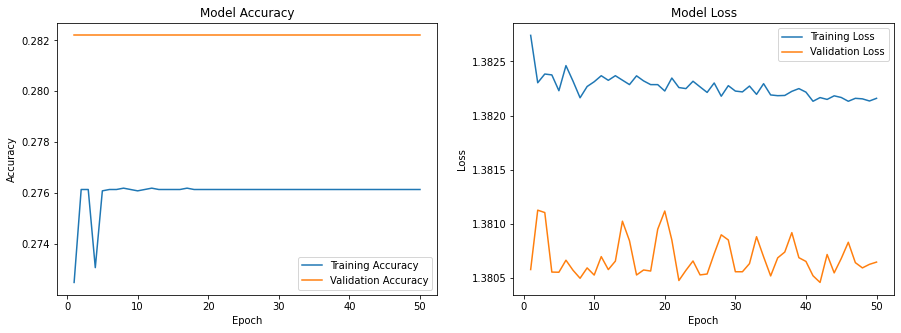

In [21]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarizing history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
    
    # Summarizing history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Loss', 'Validation Loss'], loc='best')
    plt.show()

plot_model_history(history)

In [28]:
label_predict = model.predict(pix_val)
# print(label_predict)
label_predict = np.argmax(model.predict(pix_val), axis=1)  # returns class values between 0 and 3 from highest prediction
# print(label_predict)
label_true = np.argmax(label_val, axis=1) 
# print(label_true)

target_name = ['other', 'pylorus', 'z-line', 'retroflex-stomach']
print("Classification report:\n", classification_report(label_true, label_predict, target_names=target_name))

Classification report:
                    precision    recall  f1-score   support

            other       0.00      0.00      0.00      1580
          pylorus       0.28      1.00      0.44      1777
           z-line       0.00      0.00      0.00      1629
retroflex-stomach       0.00      0.00      0.00      1311

         accuracy                           0.28      6297
        macro avg       0.07      0.25      0.11      6297
     weighted avg       0.08      0.28      0.12      6297



/home/dilara/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dilara/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dilara/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


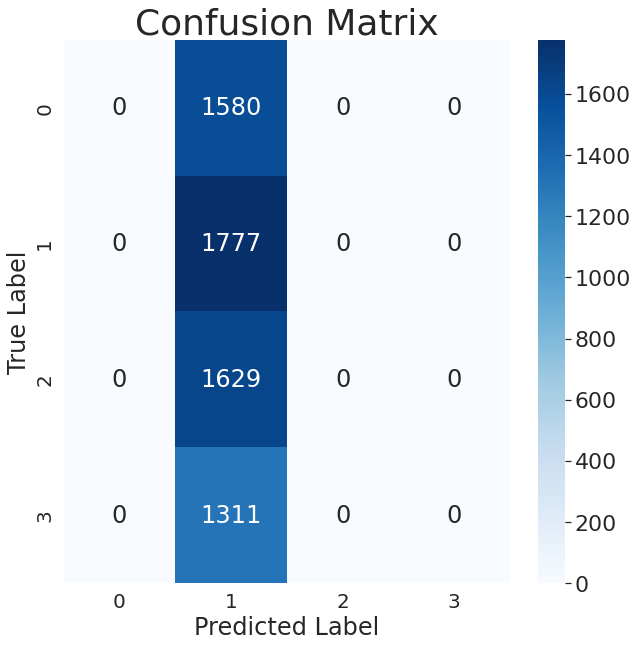

In [30]:
# Evaluating the CNN model by creating a confusion matrix
cm = confusion_matrix(label_true, label_predict)

plt.figure(figsize=(10,10))
ax = plt.subplot()

sbs.set(font_scale=2) 
sbs.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  

# Labels, title and ticks
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

title_font = {'size':'36'}  
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20) 
ax.xaxis.set_ticklabels(['0', '1', '2', '3']);
ax.yaxis.set_ticklabels(['0', '1', '2', '3']);
plt.show()